In [1]:
import Pkg
Pkg.activate("scripts") # Change this to "." incase your "scripts" is already your working directory

  Activating project at `C:\Users\adity\Julia Files\TUM Masters\Modelling and Machine Learning of Dynamical Systems in Julia\project\scripts`


In [2]:
using OrdinaryDiffEq, Flux, Optimisers, ParameterSchedulers, Random

# Not registered packages, add them manually (see comment in the Readme.md)
using LVModels, NODEData 

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\adity\.julia\packages\Flux\3711C\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [3]:
Random.seed!(1234) # We set a random seed to have reproducible results

TaskLocalRNG()

In [4]:
# Generate training data for the 2D Lotka-Volterra model
function lotka_volterra_2d!(du, u, p, t)
    x, y = u
    α, β, γ, δ = p 
    du[1] = α * x - β * x * y
    du[2] = -γ * y + δ * x * y
end

# Model parameters and initial conditions
p = Float32.([1.3, 0.9, 1.8, 0.8])
tspan, dt = (0f0, 100f0), 0.1f0
u0 = Float32.([0.44249296, 4.6280594])

# Solve the ODE
sol = solve(ODEProblem(lotka_volterra_2d!, u0, tspan, p), Tsit5(), saveat=dt)

# Create dataset with randomly missing values
t, X_sparse, mask = sparsify_data(sol; fraction=0.95) # 5% missing values for species y
train, valid = NODEDataloader(X_sparse, t, 2; valid_set=0.2)

(NODEData{Matrix{Float32},Int64} with 800 batches with length 2, NODEData{Matrix{Float32},Int64} with 199 batches with length 2)

In [5]:
# Define neural ODE model
N_weights = 32
U_nn = Chain(Dense(2, N_weights, swish), Dense(N_weights, N_weights, swish), Dense(N_weights, 2))
θ, U_re = Flux.destructure(U_nn)
p_ln = LearnableParams(θ, Float32[1.6]) # Learnable decay parameter

function neural_ode(u, p_ln::LearnableParams, t)
    x, y = u
    U = U_re(p_ln.θ)(u)
    [1.3f0 * x + U[1], -p_ln.θ1[1] * y + U[2]]
end

model = NDE(ODEProblem(neural_ode, u0, (0f0, dt), p_ln); reltol=1f-5, abstol=1f-8, dt=dt)

NDE{LearnableParams{Vector{Float32}}, ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, false, LearnableParams{Vector{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(neural_ode), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Base.Pairs{Symbol, Float32, Tuple{Symbol, Symbol, Symbol}, @NamedTuple{reltol::Float32, abstol::Float32, dt::Float32}}}(LearnableParams{Vector{Float32}}(Float32[0.35915032, 0.015010706, -0.22764586, 0.20980605, 0.21393582, 0.044137776, -0.17955789, -0.34998035, 0.16508517, 0.021672672  …  0.092640445, -0.19487306, -0.27797922, 0.12881888, -0.14223321, -0.14641641, 0.33396026, 0.33453047, 0.0, 0.0]

In [6]:
# Training setup
opt_state = Optimisers.setup(Optimisers.Adam(1f-3), model)

τ_min, τ_max, epochs = 2, 20, 20
NN_train, NN_valid = min(100, length(train)), min(100, length(valid))
scheduler = CosAnneal(1f-3, 0f0, epochs, false)

CosAnneal{Float32, Int64}(0.001f0, 0.0f0, 20, false)

In [7]:
# Training loop 
Train = false
if Train
    println("Training started...")
    for i_τ in τ_min:τ_max
        train_τ = NODEDataloader(X_sparse, t, i_τ)
        @info "Batch size = $(i_τ)"

        for epoch in 1:epochs
            η = Float32(scheduler(epoch))
            Optimisers.adjust!(opt_state, η)

            for (batch_t, batch_data) in train_τ
                batch_mask = get_mask_for_batch(batch_t, mask, t[1], dt)
                Flux.train!(model, [(batch_t, batch_data)], opt_state) do m, bt, bd
                    loss(m, (bt, bd), bd, batch_mask; λ1=1f-3, λ2=1f-4)
                end
            end

            train_loss = mean([loss(model, train[i], train[i][2], get_mask_for_batch(train[i][1], mask, t[1], dt)) for i in 1:NN_train])
            valid_loss = mean([loss(model, valid[i], valid[i][2], get_mask_for_batch(valid[i][1], mask, t[1], dt)) for i in 1:NN_valid])
            @printf("Epoch %3d | LR: %.2e | Train Loss: %.4f | Valid Loss: %.4f\n", epoch, η, train_loss, valid_loss)

        end
    end
end

In [8]:
# Prediction for the trained NODE
@load "trained NODEs\\lv_2d_scenario2.jld2" model # Load the trained model; path relative to scripts

train_70 = NODEDataloader(X_sparse, t, 70) # Training batches of size 70 for L2 error plot
mask1 = X_sparse[2, :] .!= 0  # Logical mask for nonzero elements
# Using β = p[2] and δ = p[4]
U_truth1 = -p[2] .* X_sparse[1, mask1] .* X_sparse[2, mask1]
U_truth2 = p[4] .* X_sparse[1, mask1] .* X_sparse[2, mask1]
U_truth = vcat(U_truth1', U_truth2')

plt_traj, plt_interaction, plt_l2_error, plt_re = plot_model_performance(sol, t, X_sparse, train_70, model, U_re, U_truth, mask, dt)

(Plot{Plots.GRBackend() n=4}, Plot{Plots.GRBackend() n=4}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=4})

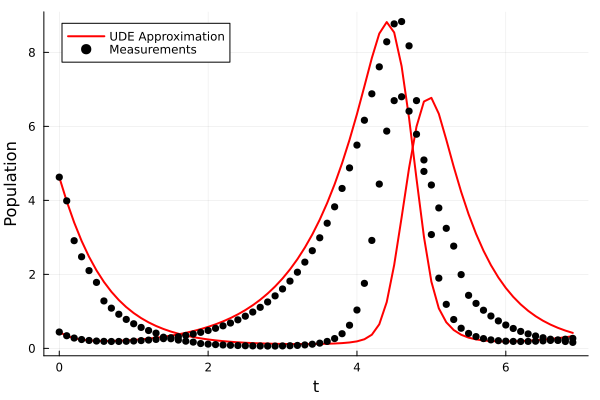

In [9]:
display(plt_traj)


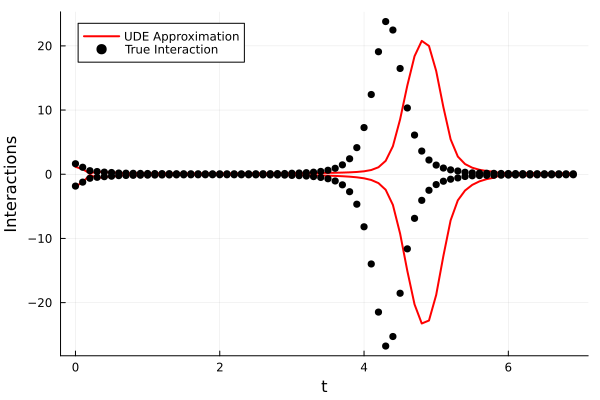

In [10]:
display(plt_interaction)


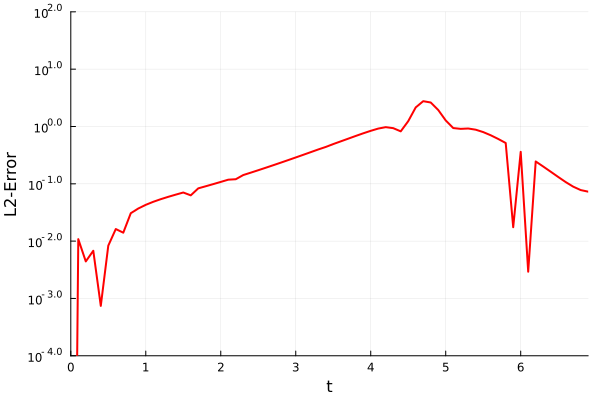

In [11]:
display(plt_l2_error)


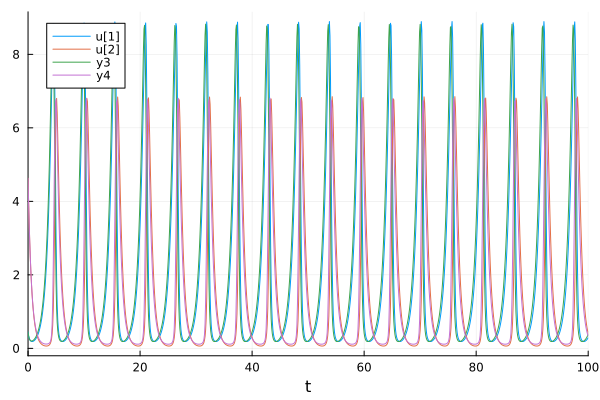

In [12]:
display(plt_re)

In [13]:
# Extract learned interactions from the neural network
mlp = U_re(model.p.θ)
dx = mlp(X_sparse)

2×1001 Matrix{Float32}:
 -1.8918   -1.25501  -0.0815265  …  -0.117961  -0.112509  -0.108369
  1.16651   0.7825    0.133428       0.156559   0.153233   0.150688

In [14]:
# Perform symbolic regression using the trained NODE
hall_of_fame, pareto_frontiers = perform_symbolic_regression(X_sparse, dx)
display(pareto_frontiers[1][3].tree)
display(pareto_frontiers[2][3].tree) 

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\adity\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Evolving for 100 iterations... 100%|█████████████████████| Time: 0:01:47


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.864e+01  1.594e+01  y = x₁
3           3.737e+00  8.035e-01  y = x₁ * x₂
5           2.797e-01  1.296e+00  y = (x₁ * 0.7534) * x₂
7           2.352e-01  8.662e-02  y = ((x₂ * 0.73071) - -0.078918) * x₁
9           2.078e-01  6.179e-02  y = x₁ * ((x₂ - (x₁ * -0.018858)) * 0.72657)
11          1.740e-01  8.881e-02  y = (x₁ * (0.90505 - (x₁ * (x₂ * 0.0063898)))) * x₂
13          1.013e-01  2.708e-01  y = ((x₁ * (1.0172 - ((x₁ * 0.009362) * x₂))) - 0.1832) * ...
                                      x₂
15          9.859e-02  1.338e-02  y = (1.0109 - ((x₁ * 0.0093877) * x₂)) * ((x₂ * (x₁ - 0.20...
                                      376)) + 0.069708)
17          6.090e-02  2.408e-01  y = (x₁ * x₂) * (0.69837 - (((x₂ - x₁) * ((x₁ + -7.0723) *...
                                       0.001792)) * x₁))
19          5.418e-02  5.847e-02  

[ Info: Final population:
[ Info: Results saved to:


(x2 * -0.85557044) * x1

(x1 * 0.7534031) * x2

In [15]:
model.p.θ1 # Learned γ decay parameter

1-element Vector{Float32}:
 1.73606